In [40]:
import os
import warnings
warnings.filterwarnings('ignore')
import math
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback









In [41]:

df = pd.read_csv("GOOGL.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)


In [42]:
df["MA50"]  = df["Close"].rolling(50,  min_periods=50).mean()
df["MA200"] = df["Close"].rolling(200, min_periods=200).mean()
df["shift1"] = df["Close"].shift(1)
df["pct"] = df["Close"].pct_change()
df = df.dropna().reset_index(drop=True)

In [43]:
y_all = df[["Close"]].astype("float32").values

split = int(len(y_all) * 0.7)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_all[:split])
y_test_scaled  = scaler_y.transform(y_all[split:])

In [44]:
def create_sequences(arr, seq_len):
    X = np.array([arr[i-seq_len:i, 0] for i in range(seq_len, len(arr))], dtype="float32")
    y = arr[seq_len:, 0]
    return X.reshape(-1, seq_len, 1), y

seq_len = 60
X_train, y_train = create_sequences(y_train_scaled, seq_len)
X_test,  y_test  = create_sequences(np.vstack([y_train_scaled[-seq_len:], y_test_scaled]), seq_len)

In [45]:

class EpochProgress(Callback):
    def __init__(self, total_epochs:int):
        super().__init__()
        self.total_epochs = total_epochs
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        tr = logs.get("loss")
        vl = logs.get("val_loss")
        msg = f"Эпоха {epoch+1}/{self.total_epochs} завершена"
        if tr is not None:
            msg += f" | loss={tr:.6f}"
        if vl is not None:
            msg += f" | val_loss={vl:.6f}"
        print(msg)

In [63]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    LSTM(100),
    Dropout(0.4),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.0248 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0024 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 0.0028 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.0023 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0022 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0025 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 0.0020 - val_loss: 0.0073 - learning_rate: 5.0000e-04
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 0.0017 - val_loss: 0.0263 - learning_rate: 5.0000e-04
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0017 - val_loss: 0.0207 - learning_rate: 5.0000e-04


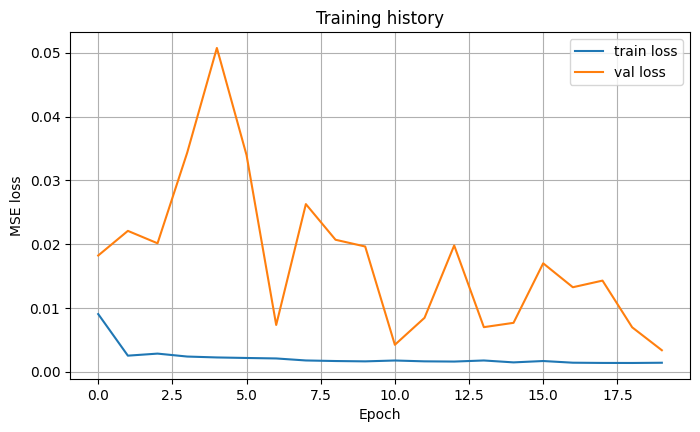

In [64]:
plt.figure(figsize=(8, 4.5))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training history")
plt.grid(True)
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred_test_scaled = model.predict(X_test, verbose=0)
pred_train_scaled = model.predict(X_train, verbose=0)

pred_test = scaler_y.inverse_transform(pred_test_scaled)
pred_train = scaler_y.inverse_transform(pred_train_scaled)

true_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))
true_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

rmse = mean_squared_error(true_test, pred_test)**(0.5)
mae  = mean_absolute_error(true_test, pred_test)
mape = float(np.mean(np.abs((true_test - pred_test) / true_test)) * 100)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")

Test RMSE: 33.2137
Test MAE : 26.0396
Test MAPE: 2.66%


In [66]:
full_true = df[["Close"]].values.astype("float32")
full_pred = np.full_like(full_true, np.nan, dtype="float32")

start_test_idx = split
full_pred[start_test_idx:start_test_idx + len(pred_test)] = pred_test


start_train_idx = seq_len
full_pred[start_train_idx:start_train_idx + len(pred_train)] = pred_train


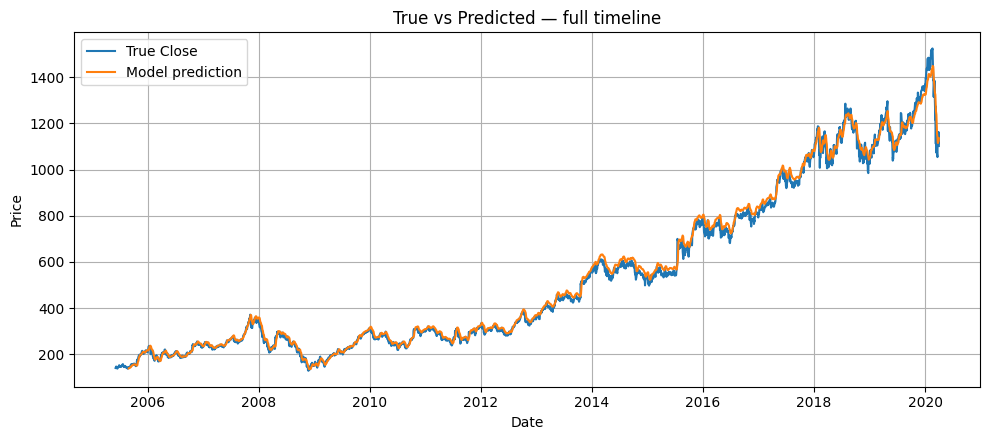

In [67]:
plt.figure(figsize=(10, 4.5))
plt.plot(df["Date"], full_true, label="True Close")
plt.plot(df["Date"], full_pred, label="Model prediction")
plt.title("True vs Predicted — full timeline")
plt.xlabel("Date"); plt.ylabel("Price")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

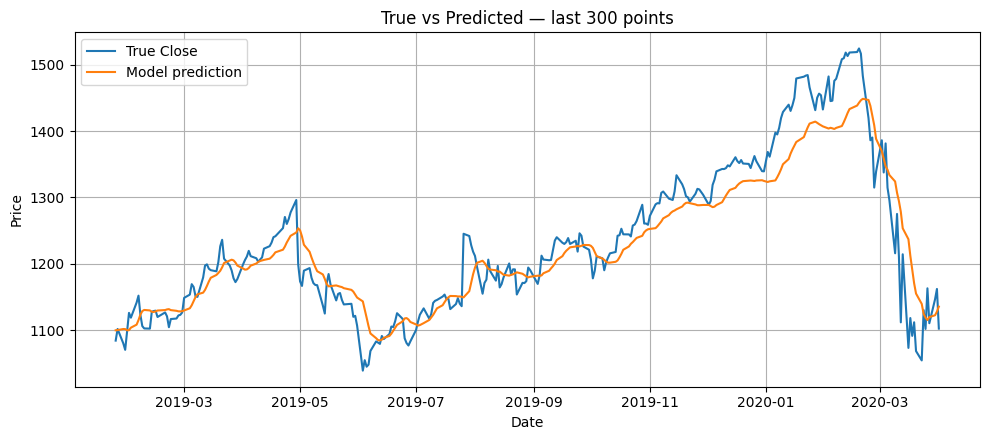

In [68]:
N = 300
plt.figure(figsize=(10, 4.5))
plt.plot(df["Date"].iloc[-N:], full_true[-N:], label="True Close")
plt.plot(df["Date"].iloc[-N:], full_pred[-N:], label="Model prediction")
plt.title(f"True vs Predicted — last {N} points")
plt.xlabel("Date"); plt.ylabel("Price")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

In [70]:
from pandas.tseries.offsets import BDay


n_future = 30
csv_path = "all_predictions_with_future.csv"


df["Date"] = pd.to_datetime(df["Date"])
y_all = df[["Close"]].astype("float32").values
y_all_scaled = scaler_y.transform(y_all)

--
pred_train_scaled = model.predict(X_train, verbose=0)
pred_test_scaled  = model.predict(X_test,  verbose=0)

pred_train = scaler_y.inverse_transform(pred_train_scaled).ravel()
pred_test  = scaler_y.inverse_transform(pred_test_scaled).ravel()


train_dates = df["Date"].iloc[seq_len:split].to_list()                           # длина = len(pred_train)
test_dates  = df["Date"].iloc[split:split + len(pred_test)].to_list()            # длина = len(pred_test)

train_df = pd.DataFrame({"Date": train_dates, "Kind": "train", "PredictedClose": pred_train})
test_df  = pd.DataFrame({"Date": test_dates,  "Kind": "test",  "PredictedClose": pred_test})


last_window = y_all_scaled[-seq_len:, 0].reshape(1, seq_len, 1)
future_scaled = []
seq = last_window.copy()
for _ in range(n_future):
    y_next_scaled = model.predict(seq, verbose=0)
    future_scaled.append(y_next_scaled[0, 0])
    seq = np.concatenate([seq[:, 1:, :], y_next_scaled.reshape(1,1,1)], axis=1)

future_preds = scaler_y.inverse_transform(np.array(future_scaled, dtype="float32").reshape(-1,1)).ravel()

last_date = df["Date"].iloc[-1]
future_dates = pd.bdate_range(start=last_date + BDay(1), periods=n_future, freq="B").to_list()

future_df = pd.DataFrame({"Date": future_dates, "Kind": "future", "PredictedClose": future_preds})


all_preds = pd.concat([train_df, test_df, future_df], ignore_index=True)


all_preds = all_preds[["Date", "Kind", "PredictedClose"]]

all_preds.to_csv(csv_path, index=False)

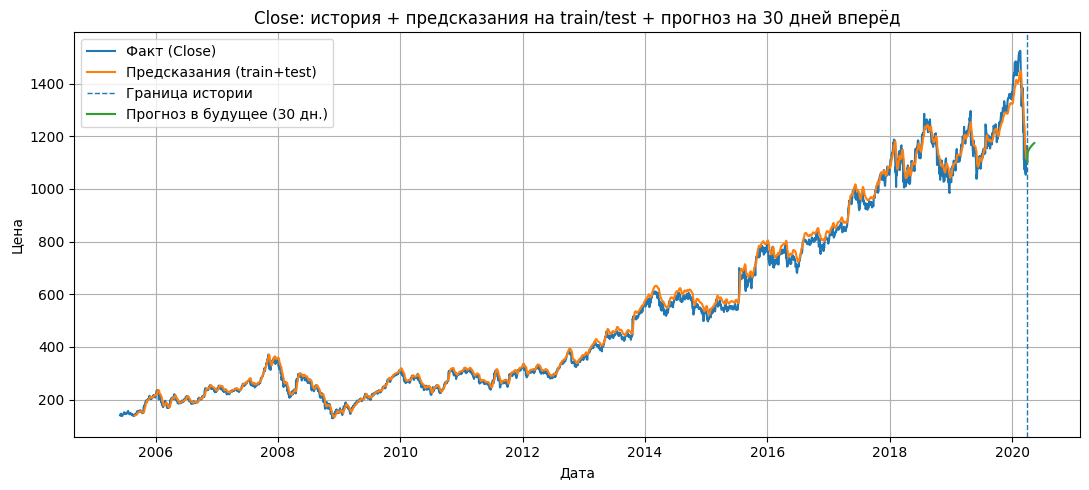

In [72]:
full_pred = np.full(shape=(len(df),), fill_value=np.nan, dtype="float32")

full_pred[seq_len:split] = pred_train


full_pred[split:split + len(pred_test)] = pred_test

plt.figure(figsize=(11, 5))

plt.plot(df["Date"], df["Close"].values, label="Факт (Close)")


plt.plot(df["Date"], full_pred, label="Предсказания (train+test)")


plt.axvline(x=last_date, linestyle="--", linewidth=1, label="Граница истории")


plt.plot([last_date] + future_dates,
         [df["Close"].values[-1]] + list(future_preds),
         label=f"Прогноз в будущее ({n_future} дн.)")

plt.title("Close: история + предсказания на train/test + прогноз на 30 дней вперёд")
plt.xlabel("Дата"); plt.ylabel("Цена")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

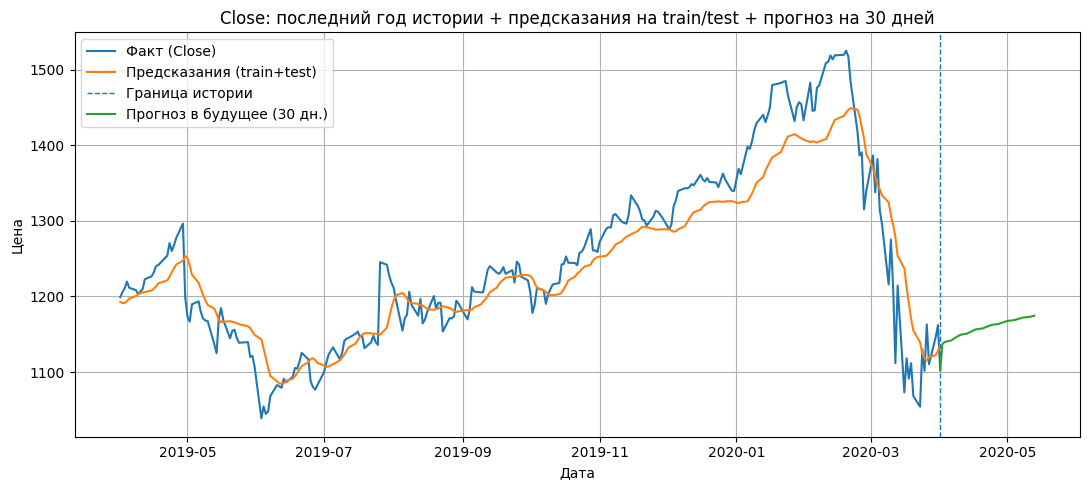

In [73]:

df["Date"] = pd.to_datetime(df["Date"])
last_date = df["Date"].iloc[-1]
window_start = last_date - pd.DateOffset(years=1)
mask = df["Date"] >= window_start



plt.figure(figsize=(11, 5))

plt.plot(df.loc[mask, "Date"], df.loc[mask, "Close"].values, label="Факт (Close)")


plt.plot(df.loc[mask, "Date"], full_pred[mask.to_numpy()], label="Предсказания (train+test)")


plt.axvline(x=last_date, linestyle="--", linewidth=1, label="Граница истории")


plt.plot([last_date] + list(future_dates),
         [df["Close"].values[-1]] + list(future_preds),
         label=f"Прогноз в будущее ({n_future} дн.)")

plt.title("Close: последний год истории + предсказания на train/test + прогноз на 30 дней")
plt.xlabel("Дата"); plt.ylabel("Цена")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()
